In [4]:
import jax
import chex
import distrax
import jax.numpy as jnp
from functools import partial
from jaxtyping import Array, Float

import matplotlib.pyplot as plt
from typing import Callable
import einops

# Sequential Monte Carlo

In this notebook, we use sequential Monte Carlo to approximate the posterior distribution of the latent variables in a Non-Markovian Gaussian sequence model.

We consider a non-Markovian Gaussian sequence model (NM-GSM) of the form

$$
\begin{aligned}
    f_t(x_t \vert x_{t-1}) &= \mathcal{N}(x_t \vert \phi x_{t-1}, q),\\
    g_t(y_t \vert x_{1:t}) &= \mathcal{N}\left(y_t \big\vert \sum_{k=1}^t \beta^{t-k} x_k, r\right).
\end{aligned}
$$

In [5]:
@chex.dataclass
class ModelParameters:
    """
    Non-Markovian Gaussian Sequence Model
    parameters of the form
    f(xt | xt-1) = N(xt | phi * xt-1, q)
    g(yt | x{1:t}) = N(yt | sum_{k=1}^t beta^{t-k} * xt, r)
    Parameters
    ----------
    phi: mean of latent conditional dependency
    beta: strength of dependence on previous latent variables
    q: variance of latent conditional dependency
    r: variance of observation conditional dependency
    """
    phi: float
    beta: float
    q: float
    r: float


@chex.dataclass
class State:
    """
    State of the NM-GSM
    x: latent variable
    mu: sum of previous latent variables
    """
    x: float
    mu: float


@chex.dataclass
class DataHist:
    """
    Data history
    """
    x: jnp.ndarray
    y: jnp.ndarray


def latent_step(key, x_prev, params):
    """
    Latent step of the Non-Markovian Gaussian Sequence Model
    """
    
#   TODO: Implement the latent step
    x = jax.random.normal(key) * jnp.sqrt(params.q) + params.phi * x_prev
    return x


def observation_step(key, x, mu, params):
    """
    Observation step of the Non-Markovian Gaussian Sequence Model
    """
    
#   TODO: Implement the observation step    
    mu_next =  params.beta * mu + x
    y = jax.random.normal(key) * jnp.sqrt(params.r) + mu_next
    return y, mu_next
    

def step(state, key, params):
    """
    Step of the Non-Markovian Gaussian Sequence Model
    """
    key_latent, key_observation = jax.random.split(key)
    x = latent_step(key_latent, state.x, params)
    y, mu = observation_step(key_observation, x, state.mu, params)

    state_next = state.replace(x=x, mu=mu)
    memory = DataHist(x=x, y=y)
    return state_next, memory


def simulate(key, params, num_steps):
    """
    Non-Markovian Gaussian Sequence Model
    """
    key_init, keys_steps = jax.random.split(key)
    keys_steps = jax.random.split(keys_steps, num_steps)
    x_init = 0.0
    state = State(x=x_init, mu=0)

    partial_step = partial(step, params=params)
    _, steps = jax.lax.scan(partial_step, state, keys_steps)

    return steps


def step_target_mean(carry_row, row, params, x_latent):
    """
    Helper function to build means of non-Markovian
    GSM one row at a time.
    """
    carry_row = carry_row * params.beta + row
    mean_val = jnp.einsum("i...,i->...", x_latent, carry_row)
    return carry_row, mean_val


def eval_observation_mean(params, x_latent):
    """
    Evaluate the means of the observation distribution
    given the latent estimates.
    """
    num_steps = x_latent.shape[0]
    init_row = jnp.zeros(num_steps)
    eval_rows = jnp.eye(num_steps)

    partial_target = partial(step_target_mean, params=params, x_latent=x_latent)
    _, means = jax.lax.scan(partial_target, init_row, eval_rows)

    return means


def step_latent_logpdf(x_prev, params):
    mean =  params.phi * x_prev
    logprob = distrax.Normal(loc=mean, scale=jnp.sqrt(params.q)).log_prob(x_prev)
    return logprob


def log_observation(x_latent, y_obs, params):
    """
    Log target density of the Non-Markovian Gaussian Sequence Model
    """
    mean_est = eval_observation_mean(params, x_latent)
    scale_est = jnp.sqrt(params.r)
    log_probs = distrax.Normal(loc=mean_est, scale=scale_est).log_prob(y_obs)
    return log_probs


def log_transition(x_latent, params):
    """
    Log target density of the Non-Markovian Gaussian Sequence Model
    """
    x_cond = jnp.roll(x_latent, 1).at[0].set(0.0) * params.phi
    log_probs = distrax.Normal(loc=x_cond, scale=jnp.sqrt(params.q)).log_prob(x_latent)
    return log_probs


partial(jax.jit, static_argnums=(2,))
def log_joint(x_latent, y_obs, params):
    """
    Log target density of the Non-Markovian Gaussian Sequence Model
    """
    log_probs = log_transition(x_latent, params) + log_observation(x_latent, y_obs, params)
    return log_probs

### simulate from the NM-GSM

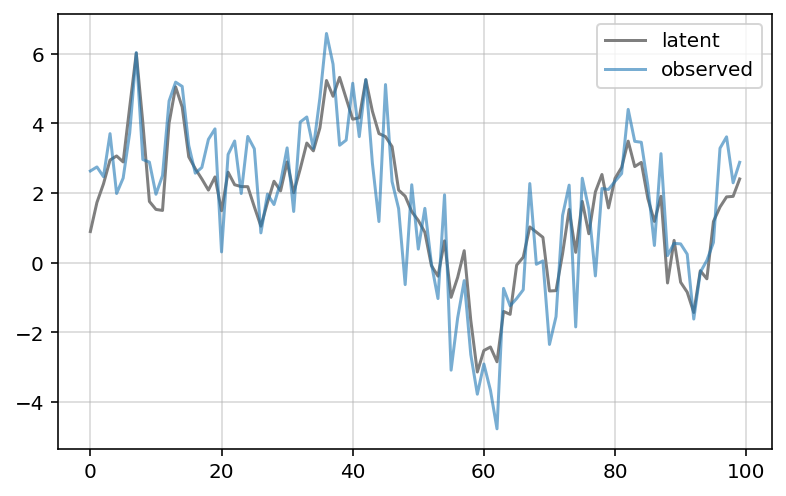

In [9]:
plt.rcParams["figure.figsize"] = [6.4, 4.0]
%config InlineBackend.figure_format = "retina"

key = jax.random.PRNGKey(314)
key_sample, key_filter = jax.random.split(key, 2)

num_steps = 100
params = ModelParameters(phi=1.0, q=1.0, beta=0.05, r=1.0)
simulation = simulate(key_sample, params, num_steps)

plt.plot(simulation.x, label="latent", c="tab:gray")
plt.plot(simulation.y, label="observed", c="tab:blue", alpha=0.6)
plt.legend()
plt.grid(alpha=0.5)

In [10]:
class BootstrapProposal:
    def __init__(self, params: ModelParameters):
        self.params = params
    
    def sample(self, key, particle_cond, step, _):
        phi = self.params.phi
        q = self.params.q
        last_sample = particle_cond[step]
        
        eps = jax.random.normal(key)
        new_sample = phi * last_sample + jnp.sqrt(q) * eps
        return new_sample
    
    def logpdf(self, x, particles, step):
        phi = self.params.phi
        q = self.params.q
        last_sample = particles[step]
        
        dist_norm = distrax.Normal(loc=last_sample * phi, scale=jnp.sqrt(q))
        return dist_norm.log_prob(x)
    
    
class Target:
    def __init__(self, params: ModelParameters):
        self.params = params
    
    def logpdf(self, particles, step, obs):
        
        num_obs = len(obs)
        particles = particles.squeeze()
        indv = jnp.arange(num_obs) <= step
        log_likelihood = log_joint(particles, obs, self.params)
        log_likelihood = jnp.einsum("n,n->", log_likelihood, indv)
        
        return log_likelihood

In [36]:
@chex.dataclass
class State:
    """
    State of the Sequential Importance Sampler
    """
    particles: Float[Array, "num_particles num_steps dim_particles"]
    log_weights: Float[Array, "num_particles"]
    step: int = 0


def _step_smc(
    key,
    state: State,
    proposal: Callable,
    y: Float[Array, "num_steps dim_obs"],
):
    """
    SMC step for a single particle.
    In this case we assume that the proposal distribution
    can consider samples from all previous and future steps.
    It's up to the user to make sure that the proposal distribution
    handles the inputs correctly.
    """
    
#     print("from _step_smc")    
#     print(f"state.particles.shape: {state.particles.shape}")
    
    key_resample, key_propagate = jax.random.split(key)
    
    # 1. TODO: Implement the resampling    
    ix_particle = jax.random.categorical(key_resample, state.log_weights)
    resample_particle = state.particles[ix_particle]
    
#     print(f"ix_particle: {ix_particle}")
#     print(f"resample_particle.shape: {resample_particle.shape}")
    
    # 2. Propagate
    particle_new = proposal.sample(key_propagate, resample_particle, state.step, y)
    
#     print(f"particle_new.shape: {particle_new.shape}")
        
    # 3. Concatenate and update state
    particles_new = resample_particle.at[state.step + 1].set(particle_new)
    
#     print(f"after concat particle_new.shape: {particle_new.shape}")
 
    return particles_new, ix_particle

    

def estimate_log_weights(particles, state_old, target, proposal, y):
    """
    Compute the unnormalised log-weights of the new (resampled) particles.
    """
    step_prev = state_old.step
    step_next = state_old.step + 1
    particle_next  = particles[:, step_next]

    target_logpdf = jax.vmap(target.logpdf, in_axes=(0, None, None))
    proposal_logpdf = jax.vmap(proposal.logpdf, in_axes=(0, 0, None))
    
#   TODO: implement the log_weights
    log_weights = (
                    + target_logpdf(particles, step_next, y) # unnormalized target eval at x{1:t}
                    - target_logpdf(particles, step_prev, y) # unnormalized target eval at x{1:t-1}
                    - proposal_logpdf(particle_next,  particles, step_prev).squeeze() # proposal eval at new particles
                    ) 
    
    return log_weights

def init_state(num_particles: int, num_steps: int, dim_particle: int):
    """
    Initialise the state of the particle SMC. We assume that the
    proposal distribution can consider samples from all previous
    steps.    
    """
    particles_init = jnp.zeros((num_particles, num_steps, dim_particle))
    log_weights_init = jnp.zeros(num_particles)

    state = State(
        step=0,
        particles=particles_init,
        log_weights=log_weights_init,
    )
    return state

def step_and_update(
    key,
    state: State,
    y: Float[Array, "num_steps dim_obs"],
    proposal: Callable,
    target: Callable,
):
    num_particles = state.particles.shape[0]
    keys = jax.random.split(key, num_particles)
    
    # Resample and propagate (#TODO: rename to `particles_resample_buffer`)
    particles_new = jax.vmap(_step_smc, in_axes=(0, None, None, None))
    
    particles_new, ix_resampled = particles_new(keys, state, proposal, y)
    
#     print(f"from step and update")
#     print(f"particles_new.shape: {particles_new.shape}")
    
    particle_new = particles_new[:, state.step + 1]    
    log_weights_new = estimate_log_weights(particles_new, state, target, proposal, y)

    state_new = state.replace(
        particles=particles_new,
        step=state.step + 1,
        log_weights=log_weights_new,
    )
    return state_new, ix_resampled, particle_new

In [37]:
num_particles = 150
dim_particle = 1

proposal = BootstrapProposal(params)
target = Target(params)


state_init = init_state(num_particles, num_steps, dim_particle)

# Initialise particles
particles_init = jax.random.normal(key_filter, (num_particles,)) * jnp.sqrt(params.q)
particles = state_init.particles.at[:, 0, 0].set(particles_init)
state_init = state_init.replace(particles=particles)

# Initialise weights
logt1 = jax.vmap(target.logpdf, (0, None, None))(state_init.particles, 1, simulation.y)
logp1 = distrax.Normal(loc=0, scale=jnp.sqrt(params.q)).log_prob(particles_init)
logw_init = logt1 - logp1
state_init = state_init.replace(log_weights=logw_init, step=0)

In [38]:
keys_filter = jax.random.split(key_filter, num_steps)

def step(state, key):
    
    state, ix_resampled, particles = step_and_update(key, state, simulation.y, proposal, target)
    
    output = {
        "log_weights": state.log_weights,
        "ix_resampled": ix_resampled,
        "particles": particles,
    }
    
#     print(key)
    return state, output

In [39]:
state, output = jax.lax.scan(step, state_init, keys_filter)
logw_hist = output["log_weights"]
ix_resampled = output["ix_resampled"]

logw_hist = jnp.roll(logw_hist, 1, axis=0).at[0].set(state_init.log_weights)
particles = jnp.roll(state.particles, 1, axis=1).at[:, 0, :].set(state_init.particles[:, 0, :])

w_hist = jnp.exp(logw_hist - jax.nn.logsumexp(logw_hist, axis=-1, keepdims=True))

In [40]:
particles = einops.rearrange(output["particles"], "timesteps particles dim -> particles (timesteps dim)")

mll_est = jax.nn.logsumexp(logw_hist, b=1/num_particles, axis=-1)
mll_true = log_observation(simulation.x, simulation.y, params)

print("Final MLL")
print(f"true: {sum(mll_true):0.4f}")
print(f"smc:  {sum(mll_est):0.4f}")

Final MLL
true: -145.7833
smc:  -198.7129


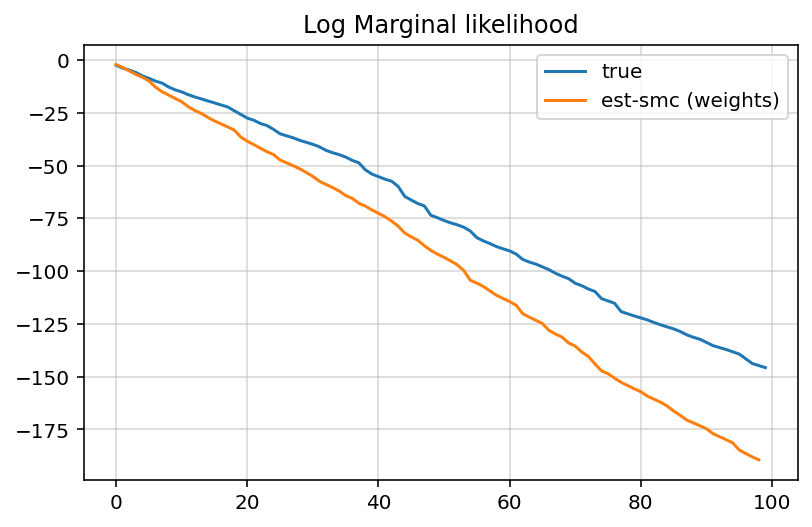

In [42]:
plt.plot(mll_true.cumsum(), label="true")
plt.plot(mll_est[1:].cumsum(), label="est-smc (weights)")
plt.legend()
plt.title("Log Marginal likelihood")
plt.grid(alpha=0.5)

## Conceptual Questions

* Why do we get an underestimate of the log normalizing constant? Hint the estimator of the normalizing constant is unbiased.
* Is there any reason why these estimates have to be monotonically decreasing?